In [27]:
# Common, File Based, and Math Imports
import pandas as pd
import numpy as np
import collections
import os
from os.path import isdir, join
from pathlib import Path
from subprocess import check_output
import sys
import math
import pickle
from glob import glob
import random
from random import sample
import json
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.lib.stride_tricks import as_strided
from tqdm import tqdm

# Audio processing
from scipy import signal
from scipy.fftpack import dct
import soundfile
import json
from python_speech_features import mfcc
import librosa
import scipy.io.wavfile as wav
from scipy.fftpack import fft
from scipy import signal

# Visualization
import IPython.display as ipd
import librosa.display
from IPython.display import Markdown, display, Audio
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

color = sns.color_palette()
sns.set_style('darkgrid')

np.random.seed(95)
RNG_SEED = 95

from io import BytesIO
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from matplotlib.dates import DateFormatter
from flask import Flask, render_template, send_file, make_response, request

In [2]:
# Function for shuffling data
def shuffle_dataset(audio_paths, durations, texts):
    p = np.random.permutation(len(audio_paths))
    audio_paths = [audio_paths[i] for i in p] 
    durations = [durations[i] for i in p] 
    texts = [texts[i] for i in p]
    return audio_paths, durations, texts

# Function for sorting data by duration
def sort_dataset(audio_paths, durations, texts):
    p = np.argsort(durations).tolist()
    audio_paths = [audio_paths[i] for i in p]
    durations = [durations[i] for i in p] 
    texts = [texts[i] for i in p]
    return audio_paths, durations, texts

# Mapping each character that could be spoken at each time step
char_map_str = """
' 0
<SPACE> 1
a 2
b 3
c 4
d 5
e 6
f 7
g 8
h 9
i 10
j 11
k 12
l 13
m 14
n 15
o 16
p 17
q 18
r 19
s 20
t 21
u 22
v 23
w 24
x 25
y 26
z 27
"""
# This leaves "blank" character mapped to number 28

char_map = {}
index_map = {}
for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)+1] = ch
index_map[2] = ' '

# Function for converting text to an integer sequence
def text_to_int_seq(text):
    int_sequence = []
    for c in text:
        if c == ' ':
            ch = char_map['<SPACE>']
        else:
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence

# Function for converting an integer sequence to text
def int_seq_to_text(int_sequence):
    text = []
    for c in int_sequence:
        ch = index_map[c]
        text.append(ch)
    return text
# Function for calculating feature dimensions.
def calc_feat_dim(window, max_freq):
    return int(0.001 * window * max_freq) + 1

In [3]:
class AudioGenerator():
    def __init__(self, step=10, window=20, max_freq=8000, mfcc_dim=13,
        minibatch_size=20, desc_file=None, spectrogram=True, max_duration=10.0, 
        sort_by_duration=False):
        # Initializing variables
        self.feat_dim = calc_feat_dim(window, max_freq)
        self.mfcc_dim = mfcc_dim
        self.feats_mean = np.zeros((self.feat_dim,))
        self.feats_std = np.ones((self.feat_dim,))
        self.rng = random.Random(RNG_SEED)
        if desc_file is not None:
            self.load_metadata_from_desc_file(desc_file)
        self.step = step
        self.window = window
        self.max_freq = max_freq
        self.cur_train_index = 0
        self.cur_valid_index = 0
        self.cur_test_index = 0
        self.max_duration=max_duration
        self.minibatch_size = minibatch_size
        self.spectrogram = spectrogram
        self.sort_by_duration = sort_by_duration

    def get_batch(self, partition):
    # Obtain a batch of audio files
        if partition == 'train':
            audio_paths = self.train_audio_paths
            cur_index = self.cur_train_index
            texts = self.train_texts
        elif partition == 'valid':
            audio_paths = self.valid_audio_paths
            cur_index = self.cur_valid_index
            texts = self.valid_texts
        elif partition == 'test':
            audio_paths = self.test_audio_paths
            cur_index = self.test_valid_index
            texts = self.test_texts
        else:
            raise Exception("Invalid partition. "
                "Must be train/val")

        features = [self.normalize(self.featurize(a)) for a in 
            audio_paths[cur_index:cur_index+self.minibatch_size]]

        # Calculate size
        max_length = max([features[i].shape[0] 
            for i in range(0, self.minibatch_size)])
        max_string_length = max([len(texts[cur_index+i]) 
            for i in range(0, self.minibatch_size)])
        
        # Initialize arrays
        X_data = np.zeros([self.minibatch_size, max_length, 
            self.feat_dim*self.spectrogram + self.mfcc_dim*(not self.spectrogram)])
        labels = np.ones([self.minibatch_size, max_string_length]) * 28
        input_length = np.zeros([self.minibatch_size, 1])
        label_length = np.zeros([self.minibatch_size, 1])
        
        for i in range(0, self.minibatch_size):
            # Calculate input_length
            feat = features[i]
            input_length[i] = feat.shape[0]
            X_data[i, :feat.shape[0], :] = feat

            # Calculate label_length
            label = np.array(text_to_int_seq(texts[cur_index+i])) 
            labels[i, :len(label)] = label
            label_length[i] = len(label)

        # Output arrays
        outputs = {'ctc': np.zeros([self.minibatch_size])}
        inputs = {'the_input': X_data, 
                  'the_labels': labels, 
                  'input_length': input_length, 
                  'label_length': label_length 
                 }
        return (inputs, outputs)

    def shuffle_dataset_by_partition(self, partition):
    # Shuffle the data
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = shuffle_dataset(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = shuffle_dataset(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/val")

    def sort_dataset_by_duration(self, partition):
    # Sort the data
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = sort_dataset(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = sort_dataset(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/val")

    def next_train(self):
    # Get a batch of training data
        while True:
            ret = self.get_batch('train')
            self.cur_train_index += self.minibatch_size
            if self.cur_train_index >= len(self.train_texts) - self.minibatch_size:
                self.cur_train_index = 0
                self.shuffle_dataset_by_partition('train')
            yield ret    

    def next_valid(self):
    # Get a batch of validation data
        while True:
            ret = self.get_batch('valid')
            self.cur_valid_index += self.minibatch_size
            if self.cur_valid_index >= len(self.valid_texts) - self.minibatch_size:
                self.cur_valid_index = 0
                self.shuffle_dataset_by_partition('valid')
            yield ret

    def next_test(self):
    # Get a batch of testing data
        while True:
            ret = self.get_batch('test')
            self.cur_test_index += self.minibatch_size
            if self.cur_test_index >= len(self.test_texts) - self.minibatch_size:
                self.cur_test_index = 0
            yield ret
            
    # Load datasets
    def load_train_data(self, desc_file='train_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'train')
        self.fit_train()
        if self.sort_by_duration:
            self.sort_dataset_by_duration('train')

    def load_validation_data(self, desc_file='valid_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'validation')
        if self.sort_by_duration:
            self.sort_dataset_by_duration('valid')

    def load_test_data(self, desc_file='test_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'test')
    
    def load_metadata_from_desc_file(self, desc_file, partition):
    # Get metadata from json corpus
        audio_paths, durations, texts = [], [], []
        with open(desc_file) as json_line_file:
            for line_num, json_line in enumerate(json_line_file):
                try:
                    spec = json.loads(json_line)
                    if float(spec['duration']) > self.max_duration:
                        continue
                    audio_paths.append(spec['key'])
                    durations.append(float(spec['duration']))
                    texts.append(spec['text'])
                except Exception as e:
                    print('Error reading line #{}: {}'
                                .format(line_num, json_line))
        if partition == 'train':
            self.train_audio_paths = audio_paths
            self.train_durations = durations
            self.train_texts = texts
        elif partition == 'validation':
            self.valid_audio_paths = audio_paths
            self.valid_durations = durations
            self.valid_texts = texts
        elif partition == 'test':
            self.test_audio_paths = audio_paths
            self.test_durations = durations
            self.test_texts = texts
        else:
            raise Exception("Invalid partition. "
             "Must be train/val/test")
            
    def fit_train(self, k_samples=100):
    # Estimate descriptive stats for training set based on sample of 100
        k_samples = min(k_samples, len(self.train_audio_paths))
        samples = self.rng.sample(self.train_audio_paths, k_samples)
        feats = [self.featurize(s) for s in samples]
        feats = np.vstack(feats)
        self.feats_mean = np.mean(feats, axis=0)
        self.feats_std = np.std(feats, axis=0)
        
    def featurize(self, audio_clip):
    # Create features from data, either spectrogram or mfcc
        if self.spectrogram:
            return spectrogram_from_file(
                audio_clip, step=self.step, window=self.window,
                max_freq=self.max_freq)
        else:
            (rate, sig) = wav.read(audio_clip)
            return mfcc(sig, rate, numcep=self.mfcc_dim)

    def normalize(self, feature, eps=1e-14):
    # Scale the data
        return (feature - self.feats_mean) / (self.feats_std + eps)

In [4]:
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
# Create a spectrogram from audio signals
    assert not np.iscomplexobj(samples), "You shall not pass in complex numbers"
    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)  
    scale = window_norm * sample_rate
    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]
    # Reshape to include the overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)
    # Window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])
    # Broadcast window, and then compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2
    # Scale 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale
    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])
    return x, freqs

def spectrogram_from_file(filename, step=10, window=20, max_freq=None,
                          eps=1e-14):
# Calculate log(linear spectrogram) from FFT energy
    with soundfile.SoundFile(filename) as sound_file:
        audio = sound_file.read(dtype='float32')
        sample_rate = sound_file.samplerate
        if audio.ndim >= 2:
            audio = np.mean(audio, 1)
        if max_freq is None:
            max_freq = sample_rate / 2
        if max_freq > sample_rate / 2:
            raise ValueError("max_freq can not be > than 0.5 of "
                             " sample rate")
        if step > window:
            raise ValueError("step size can not be > than window size")
        hop_length = int(0.001 * step * sample_rate)
        fft_length = int(0.001 * window * sample_rate)
        pxx, freqs = spectrogram(
            audio, fft_length=fft_length, sample_rate=sample_rate,
            hop_length=hop_length)
        ind = np.where(freqs <= max_freq)[0][-1] + 1
    return np.transpose(np.log(pxx[:ind, :] + eps))

In [5]:
def vis_audio_features(index, partition):
# Function for visualizing a single audio file based on index chosen
    if partition == 'validation':
        audio_gen = AudioGenerator(spectrogram=True)
        audio_gen.load_validation_data()
        vis_audio_path = audio_gen.valid_audio_paths[index]
        vis_spectrogram_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
        vis_text = audio_gen.valid_texts[index]
        vis_raw_audio, _ = librosa.load(vis_audio_path)
        return vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path
    
    elif partition == 'test':
        audio_gen = AudioGenerator(spectrogram=True)
        audio_gen.load_test_data()
        vis_audio_path = audio_gen.test_audio_paths[index]
        vis_spectrogram_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
        vis_text = audio_gen.test_texts[index]
        vis_raw_audio, _ = librosa.load(vis_audio_path)
        return vis_text, vis_raw_audio, vis_spectrogram_feature, vis_audio_path
    else:
        raise Exception('Invalid partition!  Must be "test", or "validation"')

In [6]:
# Creating visualisations for audio file at index number 2012
vis_text, vis_raw_audio, vis_spectrogram_feature, vis_audio_path = vis_audio_features(100, 'test')

In [7]:
def plot_raw_audio(vis_raw_audio):
    # Plot the raw audio signal
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot(111)
    steps = len(vis_raw_audio)
    ax.plot(np.linspace(1, steps, steps), vis_raw_audio)
    plt.title('Raw Audio Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

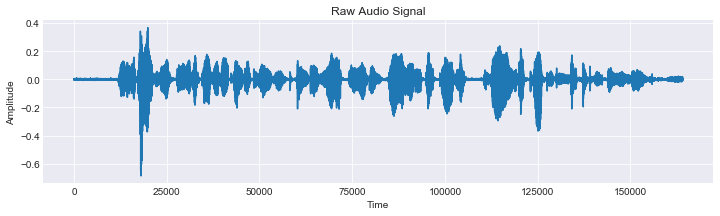

**Shape of the Audio File** : (164052,)

**Audio File Transcription** : this outward mutability indicated and did not more than fairly express the various properties of her inner life

In [8]:
# Plot the raw audio file
plot_raw_audio(vis_raw_audio)
# Printing the length of the audio file
display(Markdown('**Shape of the Audio File** : ' + str(vis_raw_audio.shape)))
# Printing the transcript corresponding to the audio file
display(Markdown('**Audio File Transcription** : ' + str(vis_text)))
# Playing the raw audio file
Audio(vis_audio_path)

In [30]:
def plot_spectrogram_feature(vis_spectrogram_feature):
    # Plot a normalized spectrogram
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    canvas = FigureCanvas(fig)
    output = BytesIO()
    canvas.print_png(output)
    response=make_response(output.getvalue())
    response.headers['Content-Type'] = 'image/png'
    return response

RuntimeError: Working outside of application context.

This typically means that you attempted to use functionality that needed
to interface with the current application object in a way.  To solve
this set up an application context with app.app_context().  See the
documentation for more information.

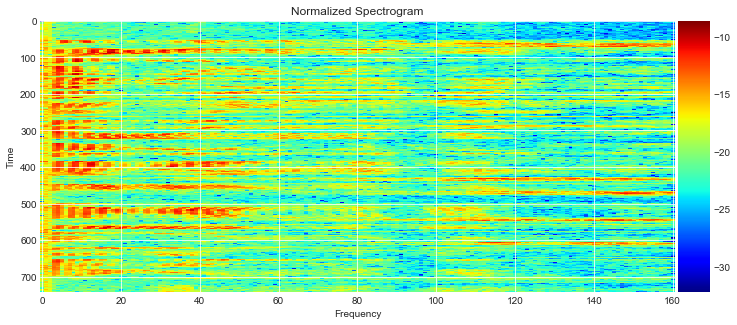

In [31]:
# Plot the spectrogram for the selected file
plot_spectrogram_feature(vis_spectrogram_feature)